OAK - logo generation

doc: https://github.com/openaiknowledge/pr3

Based on Neural style transfer: https://www.tensorflow.org/tutorials/generative/style_transfer

## Setup


### Import and configure modules

In [54]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [55]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.utils 
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy as np

from google.colab import drive

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import pathlib

import time


In [57]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [58]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

In [59]:
MAX_DIM = 512

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [60]:
def load_img(path_to_img, max_dim):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [61]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

/root/.keras/datasets/kandinsky5.jpg


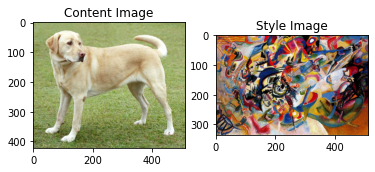

In [62]:
content_image = load_img(content_path, MAX_DIM)
style_image = load_img(style_path, MAX_DIM)
print(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Load Dataset

In [63]:
BASE_FOLDER = '/content/drive/My Drive/openaiknowledge/pr3/'
DATA = BASE_FOLDER + 'data/1/' #version 1
IMAGES = DATA + "images/"
MODEL = BASE_FOLDER + "model/1/"
IMAGES_OUT_TRAINING = IMAGES + "out_training/"
IMAGES_GENERATED = IMAGES + "generated/"

In [64]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing data

In [65]:
'''
batch_size = 32
img_height = 225 #28 #256
img_width = img_height
def preprocess_images(images):
  images = images.reshape((images.shape[0], img_height, img_width, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')
'''

"\nbatch_size = 32\nimg_height = 225 #28 #256\nimg_width = img_height\ndef preprocess_images(images):\n  images = images.reshape((images.shape[0], img_height, img_width, 1)) / 255.\n  return np.where(images > .5, 1.0, 0.0).astype('float32')\n"

(512, 511, 3)


(-0.5, 510.5, 511.5, -0.5)

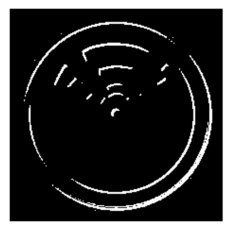

In [66]:
image_path = IMAGES + "generated/" + "hal_cvae.png"
image_path_npy = IMAGES_GENERATED+"hal_generated_gray_sobel.npy"
#hal = np.load(image_path_npy)
hal = load_img(image_path, MAX_DIM)
hal = hal[0]
print(hal.shape)
plt.imshow(hal)
plt.axis("off")

In [67]:
import cv2
'''
hal_color = cv2.cvtColor(hal, cv2.COLOR_GRAY2RGB)
plt.imshow(hal_color)
plt.axis("off")
print(hal_color.shape)
'''

'\nhal_color = cv2.cvtColor(hal, cv2.COLOR_GRAY2RGB)\nplt.imshow(hal_color)\nplt.axis("off")\nprint(hal_color.shape)\n'

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [68]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
image_to_save = tensor_to_image(stylized_image)

In [69]:
print(content_image.shape)
print(hal.shape)

(1, 422, 512, 3)
(512, 511, 3)


In [70]:
'''
hal_3 = np.reshape(hal, [225,225,1])
hal_3 = hal
print(hal_3.shape)

hal_3 = np.stack([hal_3,hal_3,hal_3],axis=2)
print(hal.shape[0])
hal_3 = np.reshape(hal_3, (hal.shape[0], hal.shape[1],3))
print(hal_3.shape)
plt.imshow(hal_3)
plt.axis("off")
'''

'\nhal_3 = np.reshape(hal, [225,225,1])\nhal_3 = hal\nprint(hal_3.shape)\n\nhal_3 = np.stack([hal_3,hal_3,hal_3],axis=2)\nprint(hal.shape[0])\nhal_3 = np.reshape(hal_3, (hal.shape[0], hal.shape[1],3))\nprint(hal_3.shape)\nplt.imshow(hal_3)\nplt.axis("off")\n'

In [71]:
'''
zeros = np.zeros([225,225,1],dtype=float)
hal_4 = np.reshape(hal, [225,225,1])

print(zeros.shape)
print(hal_3.shape)
hal_4 = np.stack([hal_4,zeros,zeros],axis=2)
print(hal.shape[0])
hal_4 = np.reshape(hal_4, (hal.shape[0], hal.shape[1],3))
print(hal_4.shape)
plt.imshow(hal_4)
plt.axis("off")
'''

'\nzeros = np.zeros([225,225,1],dtype=float)\nhal_4 = np.reshape(hal, [225,225,1])\n\nprint(zeros.shape)\nprint(hal_3.shape)\nhal_4 = np.stack([hal_4,zeros,zeros],axis=2)\nprint(hal.shape[0])\nhal_4 = np.reshape(hal_4, (hal.shape[0], hal.shape[1],3))\nprint(hal_4.shape)\nplt.imshow(hal_4)\nplt.axis("off")\n'

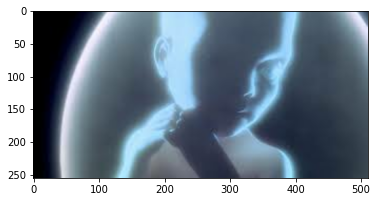

In [72]:
path_hal_styled = IMAGES + "space/space_odyssey_11.jpeg"
#path_hal_styled = IMAGES + "space/space_odyssey_14.jpeg"
hal_styled = load_img(path_hal_styled,MAX_DIM)
plt.imshow(hal_styled[0])


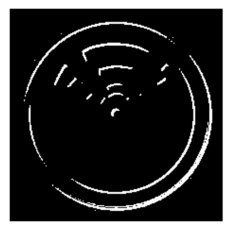

In [73]:

hal_3 = hal
plt.imshow(hal_3)

plt.axis("off")
l_hal_3 = np.resize(hal_3, (1,hal_3.shape[0], hal_3.shape[1],hal_3.shape[2]))
stylized_image = hub_model(tf.constant(l_hal_3), tf.constant(hal_styled))[0]

image_to_save = tensor_to_image(stylized_image)
path_image_to_save =  IMAGES_GENERATED + "logo.png"
image_to_save.save(path_image_to_save)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [74]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 9s 0us/step


TensorShape([1, 1000])

In [75]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317124),
 ('golden_retriever', 0.236653),
 ('kuvasz', 0.036357526),
 ('Chesapeake_Bay_retriever', 0.024182705),
 ('Greater_Swiss_Mountain_dog', 0.018646037)]

Now load a `VGG19` without the classification head, and list the layer names

In [76]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [77]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [78]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [79]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.887
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.14
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179485



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [80]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [81]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [82]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228444
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.473
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320505.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.39
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8772
    mean:  13.764149


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [83]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [84]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [85]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [86]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [87]:
style_weight=1e-2
content_weight=1e4

In [88]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [89]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

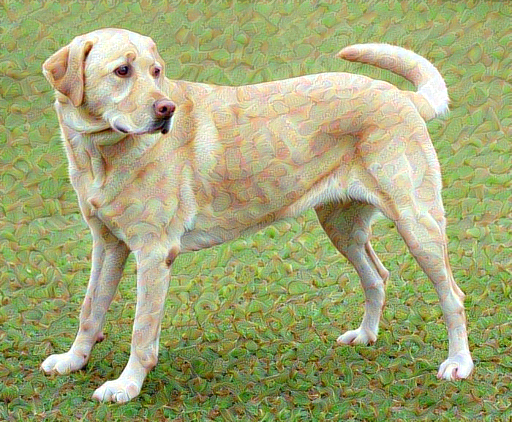

In [90]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

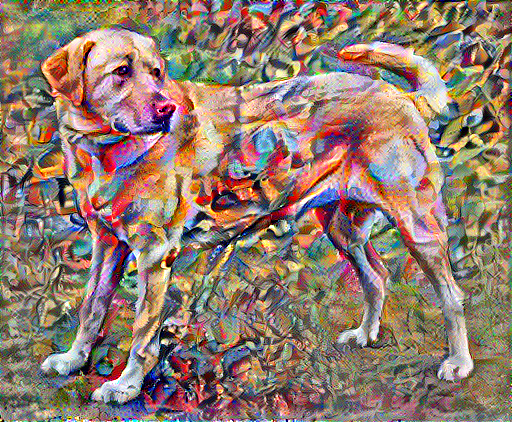

Train step: 1000
Total time: 297.3


In [91]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [92]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

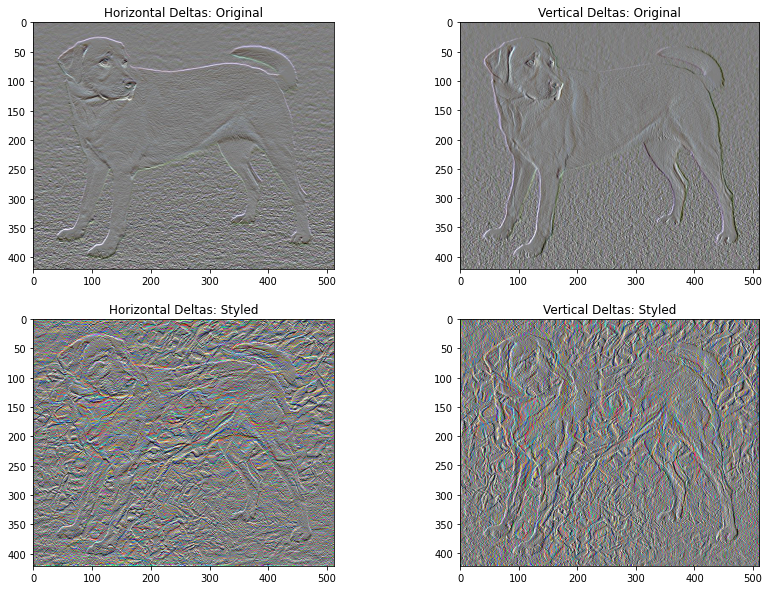

In [93]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

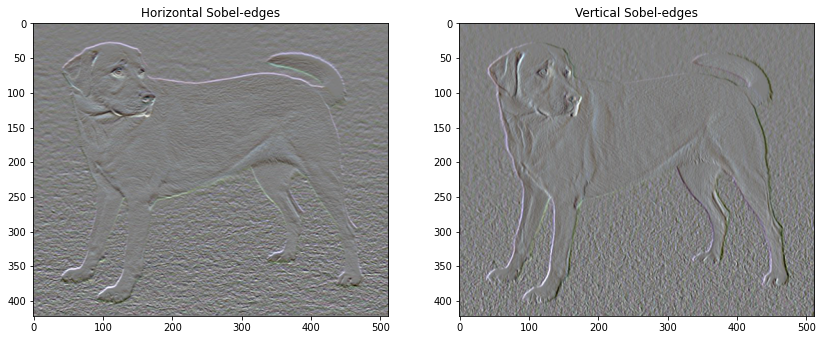

In [94]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [95]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [96]:
total_variation_loss(image).numpy()

149441.83

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [97]:
tf.image.total_variation(image).numpy()

array([149441.83], dtype=float32)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [98]:
total_variation_weight=30

Now include it in the `train_step` function:

In [99]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [100]:
image = tf.Variable(content_image)

And run the optimization:

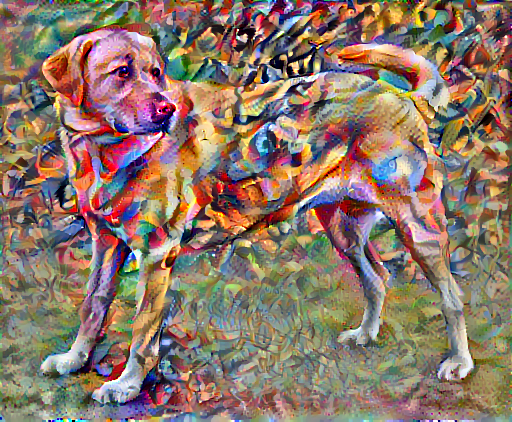

Train step: 1000
Total time: 299.3


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Learn more

This tutorial demonstrates the original style-transfer algorithm. For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the arbitrary image style transfer model from [TensorFlow Hub](https://tfhub.dev).